In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
import numpy as np
from einops import repeat, reduce, rearrange
import matplotlib.pyplot as plt

import main
import models


In [137]:
# net = models.GPT(16, 32, 64, 4, 4)
net = models.WeirdGPT(16, 32, 64, 4, 4)
# net = models.CompressionGPT(16, 32, 64, 4, 4, mode='random')
# net = models.CompressionGPT(16, 32, 64, 4, 4, mode='half-full')
logits = net(torch.randint(0, 16, (48, 32)))

In [138]:
attn_weights = torch.stack([block.attn_weights for block in net.blocks], dim=1).detach().cpu()
logits = logits.detach().cpu()
logits.shape, attn_weights.shape

(torch.Size([48, 32, 16]), torch.Size([48, 4, 4, 32, 32]))

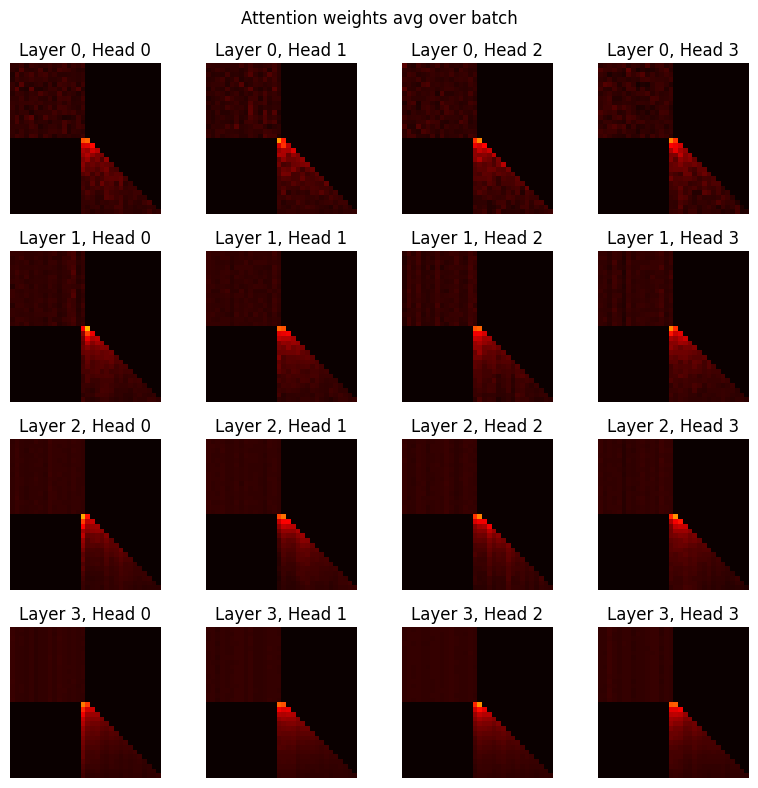

In [139]:
fig = plt.figure(figsize=(net.n_head*2, net.n_layer*2))
for i_layer in range(net.n_layer):
    for i_head in range(net.n_head):
        plt.subplot(net.n_layer, net.n_head, i_layer*net.n_head + i_head + 1)
        plt.imshow(attn_weights[:, i_layer, i_head].mean(dim=0), cmap='hot', vmin=0., vmax=1.)
        plt.title(f'Layer {i_layer}, Head {i_head}')
        plt.axis('off')
        # y = torch.where(~logits.isnan().any(dim=-1).any(dim=0))[0].detach().cpu().numpy()
        # x = np.full(len(y), fill_value=-1)
        # plt.scatter(x, y, marker='x', color='g', s=10)
plt.suptitle('Attention weights avg over batch')
plt.tight_layout()

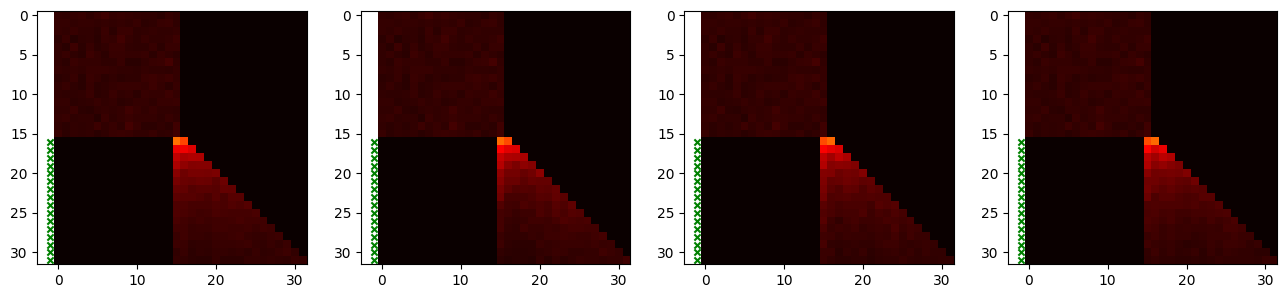

In [136]:
fig = plt.figure(figsize=(4*4, 4))
for i_batch in range(4):
    plt.subplot(1, 4, i_batch + 1)
    plt.imshow(attn_weights[i_batch].mean(dim=(0, 1)), cmap='hot', vmin=0, vmax=1)
    y = torch.where(~logits.isnan().any(dim=-1)[i_batch])[0].numpy()
    x = np.full(len(y), fill_value=-1)
    plt.scatter(x, y, marker='x', color='g', s=20)

In [45]:
mha = nn.MultiheadAttention(32, 4, batch_first=True)

In [133]:
x = torch.randn(16, 20, 32)
q = torch.randn(16, 10, 32)
mask = torch.triu(torch.ones(16, 4, 10, 20, dtype=torch.bool), diagonal=1).reshape(64, 10, 20)
mha(q, x, x, attn_mask=mask)[0].shape

torch.Size([16, 10, 32])

torch.Size([16, 32])


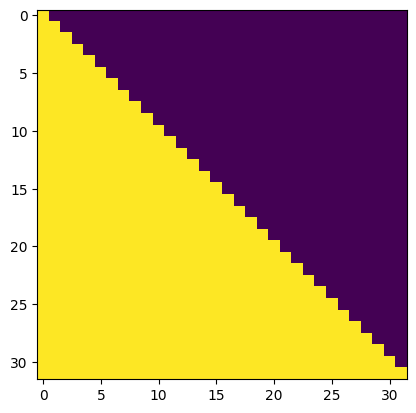

In [154]:
net = models.GPT(32, 32, 32, 4, 4)
tok = torch.randint(0, 32, size=(16, 33))
print(net.loss_fn(tok).shape)
plt.imshow(net.blocks[0].mask)

torch.Size([16, 16])


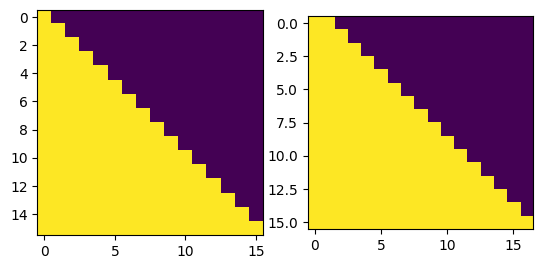

In [157]:
net = models.Compression2AK(32, 32, 32, 4, 4)
tok = torch.randint(0, 32, size=(16, 33))
print(net.loss_fn(tok, i=16).shape)
plt.subplot(121); plt.imshow(net.encoder.blocks[3].mask)
plt.subplot(122); plt.imshow(net.decoder.blocks[3].mask)

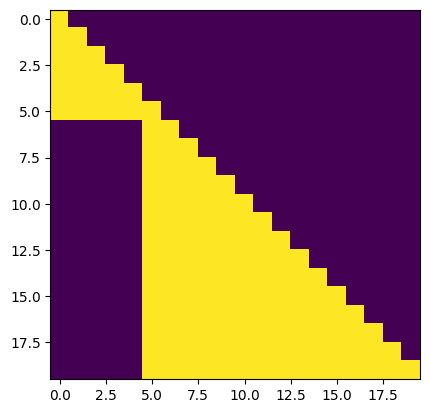

In [218]:
import matplotlib.pyplot as plt
import torch

block_size = 20
mask = torch.tril(torch.ones(block_size, block_size, dtype=torch.bool))
idx_dec = np.random.randint(0, block_size)
mask[idx_dec:, :idx_dec] = False
mask[idx_dec:, np.clip(idx_dec-1, 0, None)] = True
plt.imshow(mask)
plt.show()

In [98]:
vocab_size = 32
block_size = 20
n_embd = 48

bs = 32

net = models.CompressionGPT(vocab_size, block_size, n_embd, 4, 4)

In [99]:
tok = torch.randint(0, vocab_size, size=(bs, block_size))
logits = net(tok)

In [100]:
logits.shape

torch.Size([32, 20, 32])

In [103]:
logits.nanmean(dim=0).isnan().any(dim=-1)

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False])

In [105]:
logits[0].mean(dim=-1)

tensor([   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan, 0.0172, 0.0136, 0.0148, 0.0138,
        0.0165, 0.0135], grad_fn=<MeanBackward1>)

In [107]:
nn.functional.cross_entropy(logits[0], torch.zeros(20, dtype=torch.long), reduction="none")

tensor([   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan, 3.4423, 3.4752, 3.4959, 3.5617,
        3.6006, 3.5626], grad_fn=<NllLossBackward0>)

In [319]:
net = models.GPT(32, 32, 768, 12, 12, mask='causal')
tok = torch.randint(0, 32, size=(16, 10))
logits = net(tok)

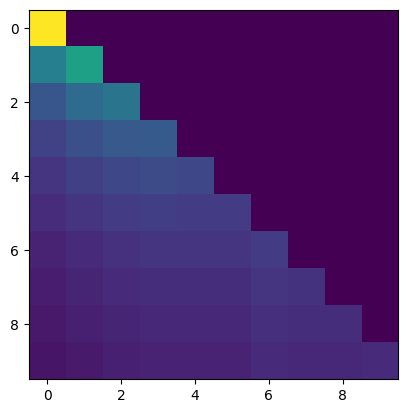

In [324]:
plt.imshow(net.blocks[-1].attn_weights[7, 8].detach().cpu().numpy())

In [306]:
tok = main.generate_batch(10, 10, 10000, device="cpu")
# tok = torch.stack([torch.randperm(30) for _ in range(10000)])

In [307]:
tok.shape

torch.Size([10000, 10])

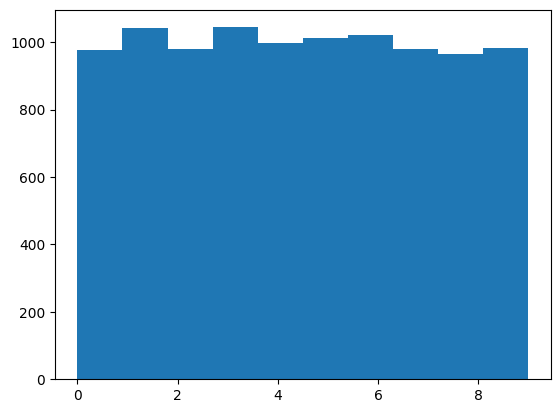

In [308]:
plt.hist(tok[:, 0].flatten().numpy());

In [31]:
torch.__version__

'2.0.1'

In [39]:
net = models.CompressionGPT(33, 32, 768, 4, 12, mode='half')
tok = main.generate_batch(33, 32 + 1, 16, device='cpu')
x, y = tok[:, :-1], tok[:, 1:]
logits = net(x)

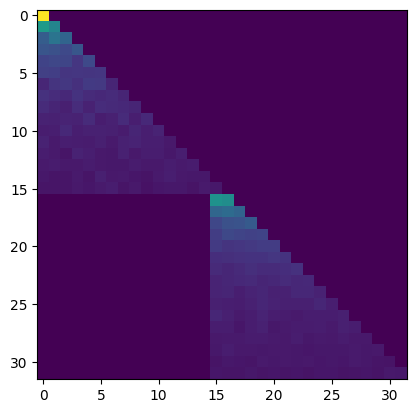

In [44]:
plt.imshow(net.blocks[0].attn_weights.mean(dim=(0, 1)).cpu().detach().numpy())

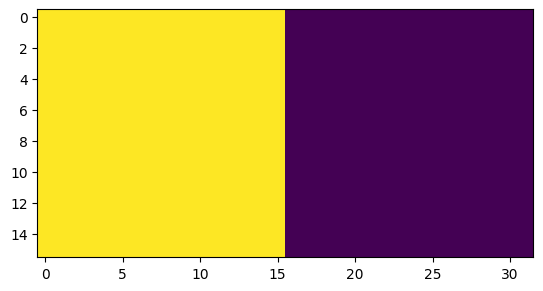

In [48]:
plt.imshow(net.create_compression_batch_mask(torch.arange(32), net.idxs_dec))